This notebook
 * checks the mask,
 * displays the simulation maps, both ILC and noise,
 * derives the transfer-function,
 * calculates the central noise level
 * calculates tniti

In [5]:
import numpy as np
import healpy as hp
import os, sys
from astropy.io import fits
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.gridspec as gridspec

import component_separation.MSC.MSC.pospace as ps

from lerepi.config.cmbs4.data import data_08d as sims_if
sims  = sims_if.ILC_May2022('00')

simids = np.array([0])
nside = 2048
lmax = 2047
lmax_plot = lmax

ll = np.arange(0,lmax_plot+1,1)
binspace = 5
scale_uk = (2 * ll + 1) * ll**2 * (ll + 1)**2
scale_ps = ll*(ll+1)/(2*np.pi)
label_scale_ps = r'$\frac{\ell(\ell+1)}{2 \pi}$'
label_scale_lp = r'$\frac{\ell^2(\ell+1)^2}{2 \pi}$'
scale_lp = ll**2 * (ll + 1)**2 * 1e7 / (2 * np.pi)

psl = r'$\frac{l(l+1)}{2\pi}C_\ell \/ [\mu K^2]$'

MSC: reverting to standard healpy


In [6]:
def bandpass_alms(alms, lmin, lmax=None):
    """
    lmin: minimum multipole to keep in alms
    lmax: maximimum multipole to keep in alms
    """
    
    if len(alms) == 3:
        out = np.zeros(alms.shape, dtype=complex)
        for idx, _alms in enumerate(alms):
            out[idx] = bandpass_alms(_alms, lmin, lmax=lmax)
        return out
    
    lmax_in_alms = hp.Alm.getlmax(len(alms))
    if lmax is None:
        lmax = lmax_in_alms
    else:
        assert isinstance(lmax, int), "lmax should be int: {}".format(lmax)
        assert lmax <= lmax_in_alms, "lmax exceeds lmax in alms: {} > {}".format(lmax, lmax_in_alms)
    
    fl = np.zeros(lmax_in_alms + 1, dtype=float)
    fl[lmin:lmax+1] = 1
    
    return hp.almxfl(alms, fl)

# Tiniti

In [3]:
oldtiniti = np.load('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_test/OBD_matrix/tniti.npy')
newtiniti = np.load('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_test2/OBD_matrix/tniti.npy')
# oldtiniti = np.load('/global/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/mapphi_intermediate/s08d/tniti.npy')

(5000.0, 6000.0)

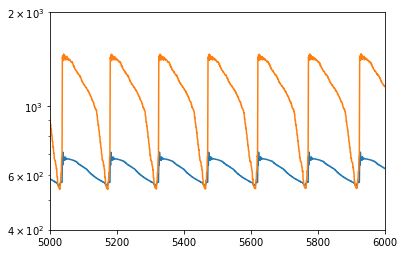

In [18]:
plt.plot(np.diag(newtiniti))
plt.plot(np.diag(oldtiniti)*3)
plt.yscale('log')
plt.ylim(4e2,2e3)
plt.xlim(5000, 6000)

(1.0, 3.0)

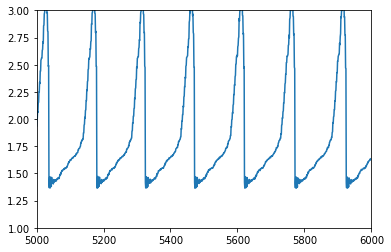

In [15]:
plt.plot(np.diag(newtiniti)/np.diag(oldtiniti))
plt.xlim(5000, 6000)
plt.ylim(1,3)
# np.sum(newtiniti)-np.sum(oldtiniti)

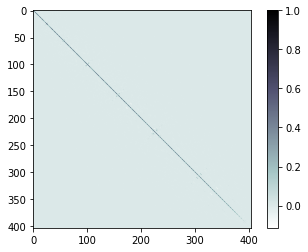

In [13]:
plt.imshow(newtiniti[::100,::100]/np.max(newtiniti[::100,::100]), cmap='bone_r')
plt.colorbar()

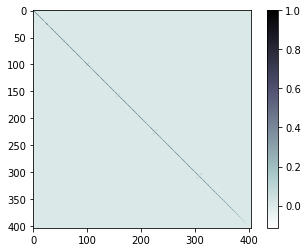

In [14]:
plt.imshow(oldtiniti[::100,::100]/np.max(oldtiniti[::100,::100]), cmap='bone_r')
plt.colorbar()

# OBD

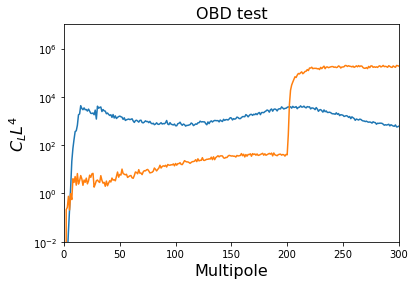

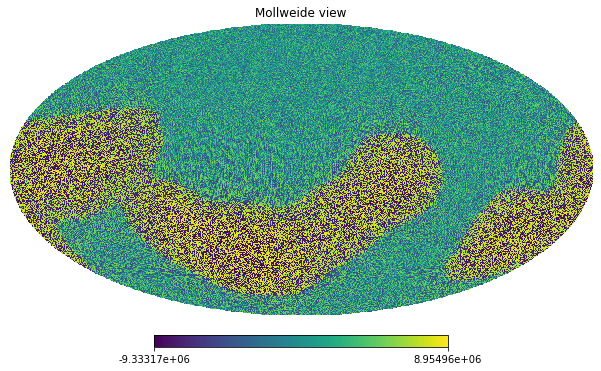

In [67]:
elm = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r100/ivfs/sim_0000_elm.fits')
blm = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r100/ivfs/sim_0000_blm.fits')
plt.plot(hp.alm2cl(elm), label='ClEE')
plt.plot(hp.alm2cl(blm), label='ClBB')

plt.title('OBD test', fontsize=16)
plt.xlabel('Multipole', fontsize=16)
plt.ylabel('$C_L L^4$', fontsize=16)

plt.yscale('log')
plt.ylim(1e-2,1e7)
plt.xlim(0,300)
plt.show()
bmap = hp.alm2map(blm, nside=2048)
hp.mollview(bmap, norm='hist')

Text(-1.3413895611048, 0.5185471423507488, 'r10 redi imdi solver')

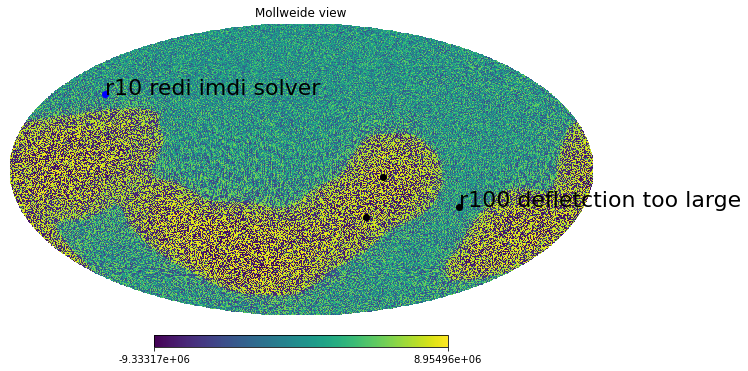

In [78]:
hp.mollview(bmap, norm='hist')
hp.visufunc.projscatter(theta=1.6296791075465420, phi=5.3988851528357928, lonlat=False, color='black')
hp.visufunc.projscatter(theta=1.9861162068333398, phi=5.5411476673863715, lonlat=False, color='black')
hp.visufunc.projscatter(theta=1.8924901406264949, phi=4.5318296886833762, lonlat=False, color='black')
hp.visufunc.projtext(theta=1.8924901406264949, phi=4.5318296886833762, lonlat=False, s='r100 defletction too large', fontsize=22)
hp.visufunc.projscatter(theta=141.19080289257585, phi=39.000000000000000, lonlat=True, color='blue')     
hp.visufunc.projtext(theta=141.19080289257585, phi=39.000000000000000, lonlat=True, s='r10 redi imdi solver', fontsize=22)

# qlm

In [20]:
qlm1 = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_test/qlms_dd/sim_p_p_0000.fits')
qlm2 = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_test/qlms_dd/sim_p_p_0001.fits')
qmap1 = hp.alm2map(bandpass_alms(qlm1,30,200), nside=2048)
qmap2 = hp.alm2map(bandpass_alms(qlm2,30,200), nside=2048)

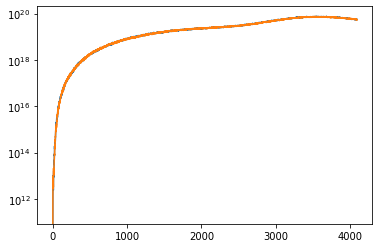

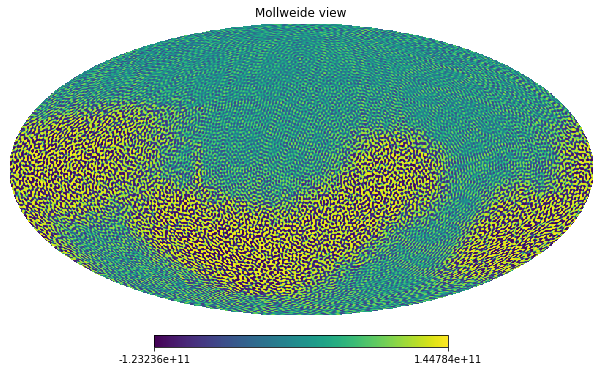

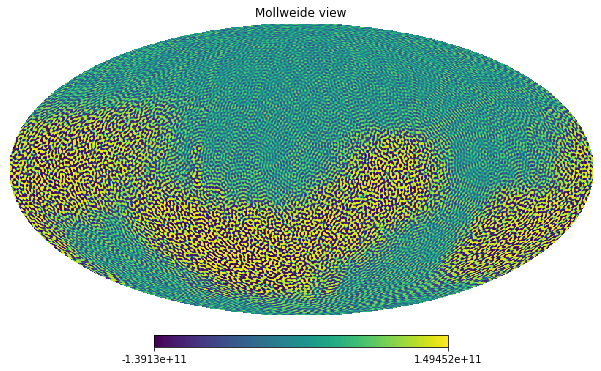

In [21]:
plt.plot(hp.alm2cl(qlm1), label='qlm')
plt.plot(hp.alm2cl(qlm2), label='qlm')
plt.yscale('log')
# plt.ylim(1e2,1e7)
# plt.xlim(0,300)
plt.show()

hp.mollview(qmap1, norm='hist')
hp.mollview(qmap2, norm='hist')

# Meanfield

In [92]:
mf = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/qlms_dd/simMF_k1p_p_135b0ca72339ac4eb092666cd7acb262a8ea2d30.fits')

mf_map = hp.alm2map(bandpass_alms(mf,30,200), nside=2048)

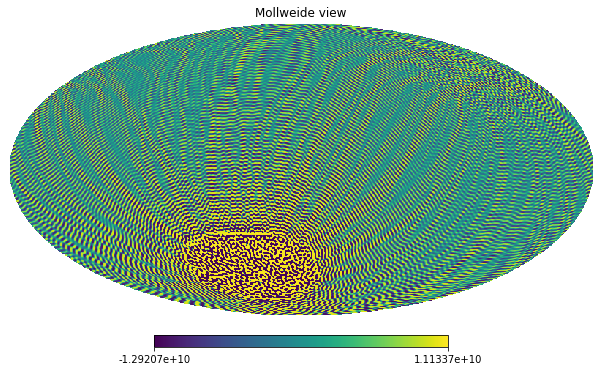

In [93]:
hp.mollview(mf_map, norm='hist')#, norm='hist')

In [9]:
mf2 = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_test2/qlms_dd/simMF_k1p_p_135b0ca72339ac4eb092666cd7acb262a8ea2d30.fits')
mf_map2 = hp.alm2map(bandpass_alms(mf2,30,200), nside=2048)

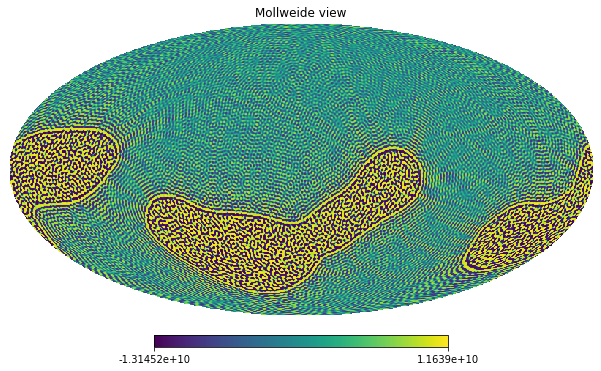

In [10]:
hp.mollview(mf_map2, norm='hist')

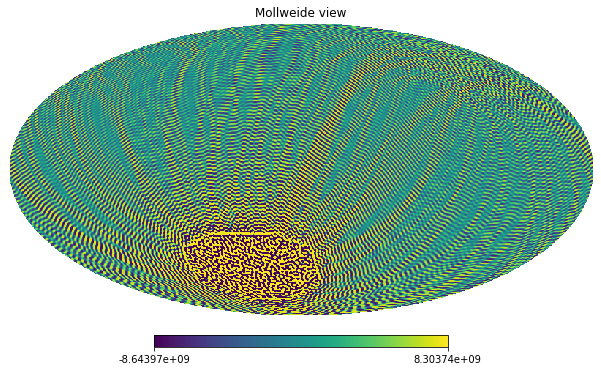

In [12]:
mf3 = np.load('/global/cscratch1/sd/sebibel/cmbs4/s08b/cILC2021_00_lmax4000/zb_terator_p_p_0000_nofg_OBD_solcond_3apr20/mf.npy')
mf_map3 = hp.alm2map(bandpass_alms(mf3,30,200), nside=2048)
hp.mollview(mf_map3, norm='hist')

# Plm

*** Could only build up to itr number 10


Text(0.5, 1.0, 'Lensing potential spectrum')

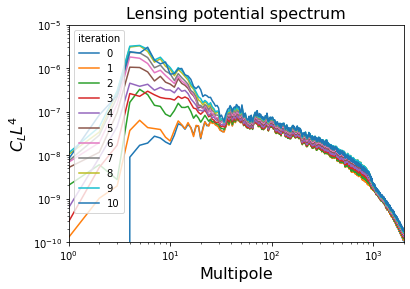

In [7]:
from lenscarf.iterators.statics import rec as rec
libdir_iterator = '/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r5/p_p_sim0000/'
plms = rec.load_plms(libdir_iterator, range(12))
for n in range(len(plms)):
    pcl = hp.alm2cl(plms[n])
    plt.plot(pcl*np.arange(len(pcl))**4, label=n)
plt.xscale('log')
plt.yscale('log')
plt.legend(title='iteration')
plt.xlim(1e0,2e3)
plt.ylim(1e-10,1e-5)
plt.xlabel('Multipole', fontsize=16)
plt.ylabel('$C_L L^4$', fontsize=16)
plt.title('Lensing potential spectrum', fontsize=16)

In [8]:
pmaps_bp = np.array([hp.alm2map(bandpass_alms(p,30,1000), nside=2048) for p in plms])

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


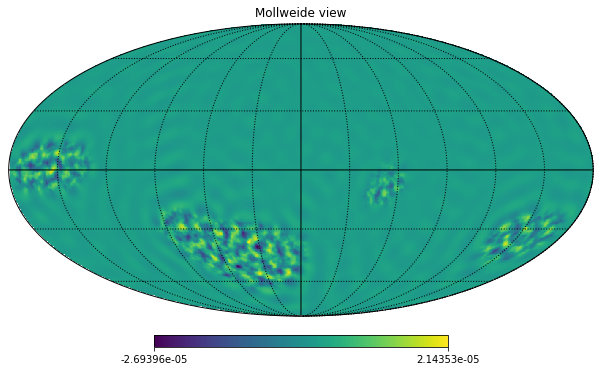

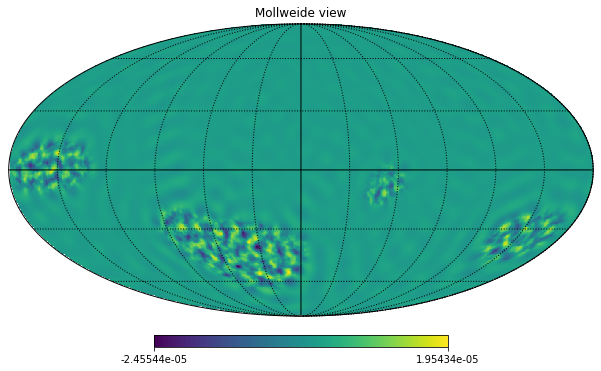

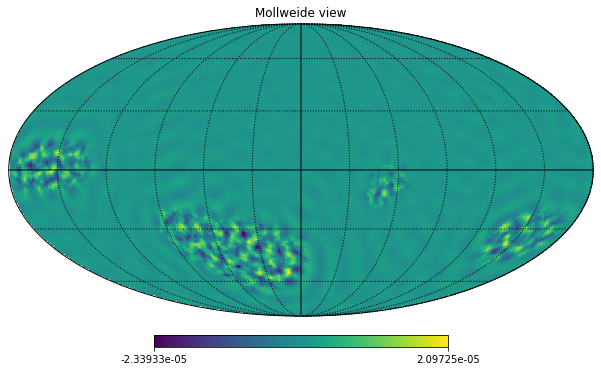

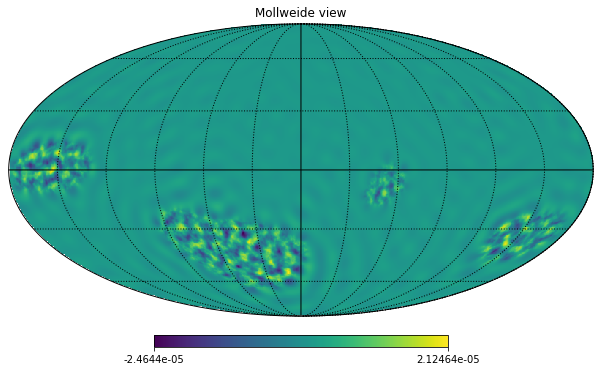

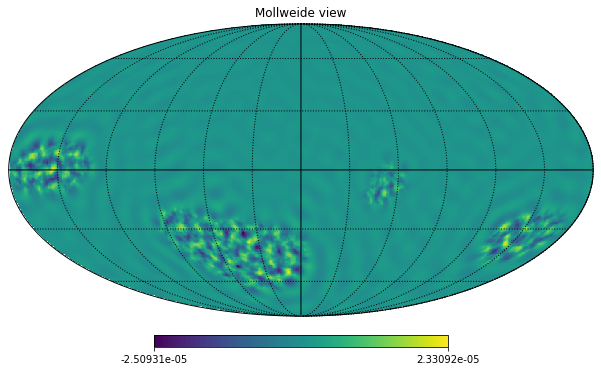

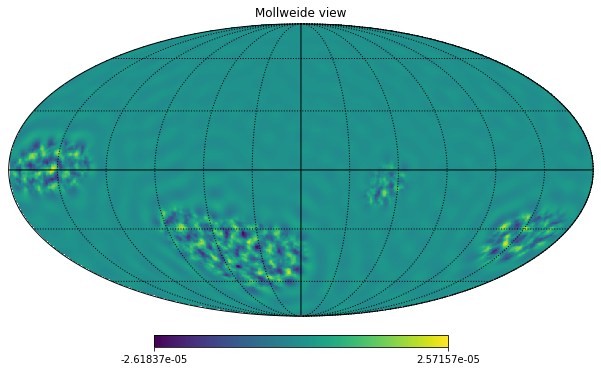

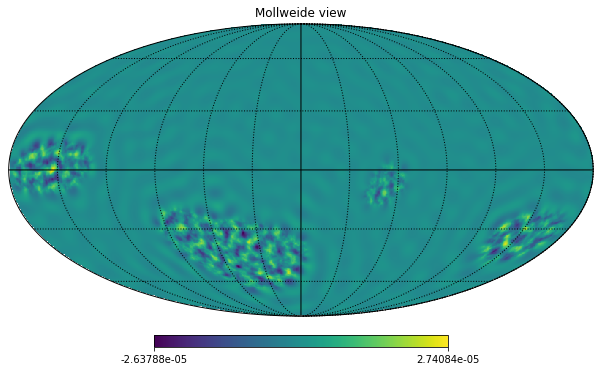

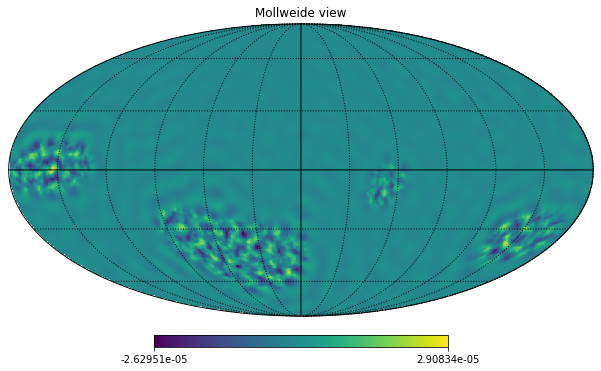

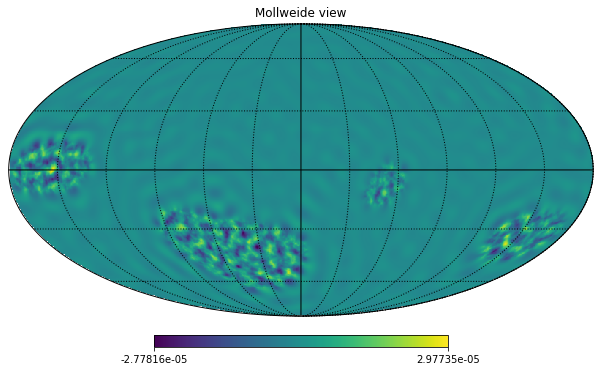

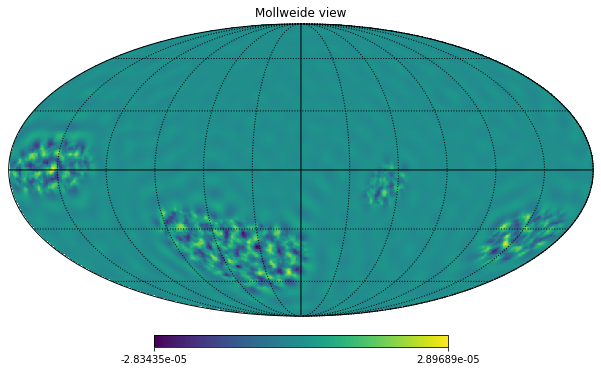

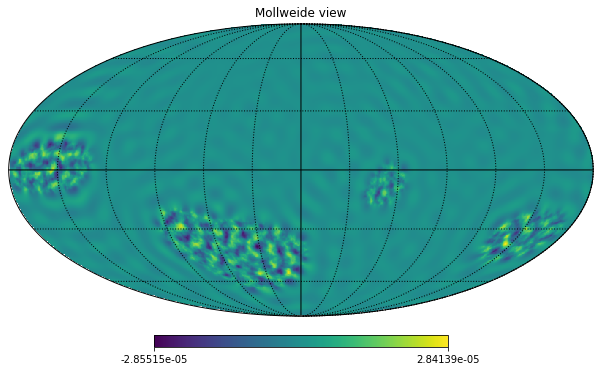

In [10]:
for p in pmaps_bp:
    hp.mollview(p)
    hp.graticule()

In [50]:
from plancklens.sims import planck2018_sims
from plancklens import utils
idx = 0
beam = 2.3
m0 = hp.read_map('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r5/ivfs/fmask.fits.gz')
transf_elm_loc = hp.gauss_beam(beam/180 / 60 * np.pi, lmax=4000)
blm_L_buff = hp.almxfl(utils.alm_copy(planck2018_sims.cmb_unl_ffp10.get_sim_plm(idx), lmax=4000), transf_elm_loc)
bmap_L_buff = hp.alm2map(blm_L_buff, 2048)*m0
blm_L_buff_scaled = hp.map2alm(bmap_L_buff, lmax=4000)
# bcl_L_nm = self.lib_nm[nlev].map2cl(bmap_L_buff)
# self.lib_nm.update({nlev: ps.map2cl_binned(nlev_mask, self.bmd_model.clc_templ[:self.bmd_model.lmax_lib], self.bmd_model.edges, self.bmd_model.lmax_lib)})

(0.0, 2000.0)

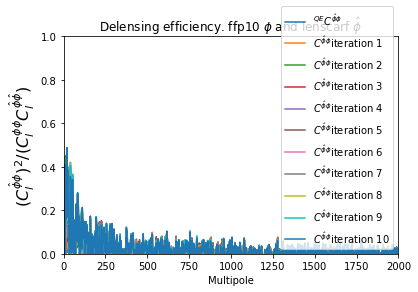

In [51]:
ls = np.arange(2,2500)
for idx, pout in enumerate(plms):
    if idx == 0:
        label = r'$^{QE}C^{\hat{\phi}\phi}$'
    else:
        label = r'$C^{\hat{\phi}\phi}$'+ 'iteration {}'.format(range(12)[idx])
    plt.plot(ls, (hp.alm2cl(pout, blm_L_buff_scaled)[ls]/np.sqrt(hp.alm2cl(blm_L_buff_scaled)[ls] * hp.alm2cl((pout))[ls])), label=label)

    plt.title(r'Delensing efficiency. ffp10 $\phi$ and lenscarf $\hat{\phi}$')
plt.xlabel('Multipole')
plt.ylabel(r'$(C_l^{\hat{\phi}\phi})^2/(C_l^{\phi\phi}C_l^{\hat{\phi}\hat{\phi}})$', fontsize=16)
plt.legend()

plt.ylim((0.0,1))
plt.xlim((0,2000))

In [45]:
blm_L_buff_scaled.shape
# pout.shape

(8394753,)

0.0 0.28284264067589 -180.0 180.0


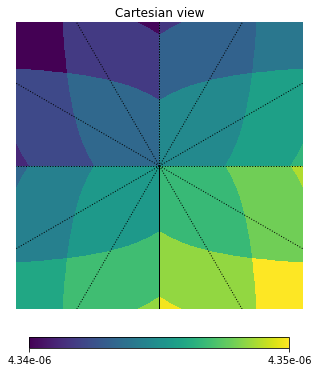

In [86]:
hp.cartview(pmap, lonra=[-0.1,0.1], latra=[-0.1,0.1], rot=[0,90,0] )
hp.graticule()

# Wflm

In [47]:
wflm = np.array([np.load('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_test2/p_p_sim0000/wflms/wflm_p_it%d.npy'%it) for it in range(1)])
wflm2 = np.array([np.load('/global/cscratch1/sd/sebibel/cmbs4/s08b/cILC2021_00_lmax4000/zb_terator_p_p_0000_nofg_OBD_solcond_3apr20/wflms/wflm_p_it%d.npy'%it) for it in range(1)])

(1e-07, 1.0)

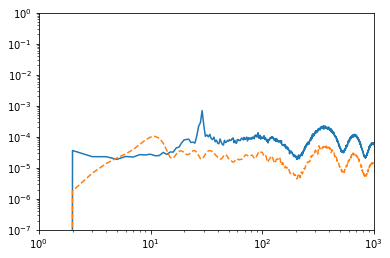

In [48]:
for n in range(1):
    plt.plot(hp.alm2cl(wflm[n]))
    plt.plot(hp.alm2cl(wflm2[n]), ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e0,1e3)
plt.ylim(1e-7,1e0)

In [79]:
wmap = hp.alm2map(bandpass_alms(wflm[0],10,1000), nside=2048)

0.0 45.0 -180.0 180.0


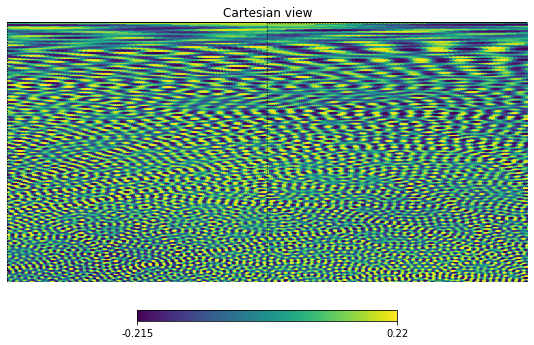

In [83]:
hp.cartview(wmap, lonra=[60,120], latra=[60,90], norm='hist', rot=[0,0,0])
hp.graticule()

# sim_p_p, x_p

In [ ]:
p_p = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_test/qlms_dd/sim_p_p_0000.fits')
x_p = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_test/qlms_dd/sim_x_p_0000.fits')

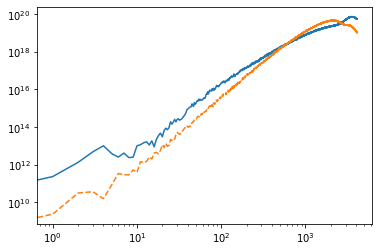

In [ ]:
for n in range(1):
    plt.plot(hp.alm2cl(p_p))
    plt.plot(hp.alm2cl(x_p), ls='--')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(1e0,1e3)
# plt.ylim(1e-7,1e0)

# Mask

In [2]:
import healpy as hp
m0 = hp.read_map('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r5/ivfs/fmask.fits.gz')
m1 = hp.read_map('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r10/ivfs/fmask.fits.gz')
m2 = hp.read_map('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r100/ivfs/fmask.fits.gz')

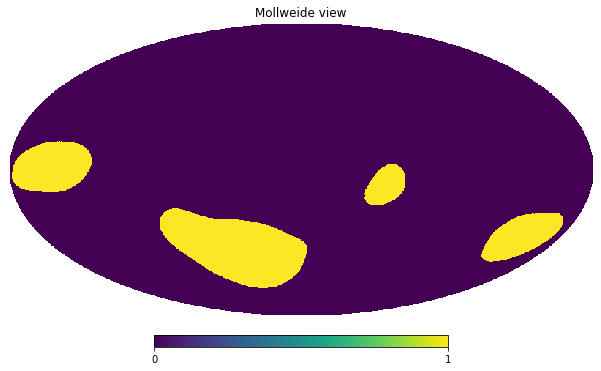

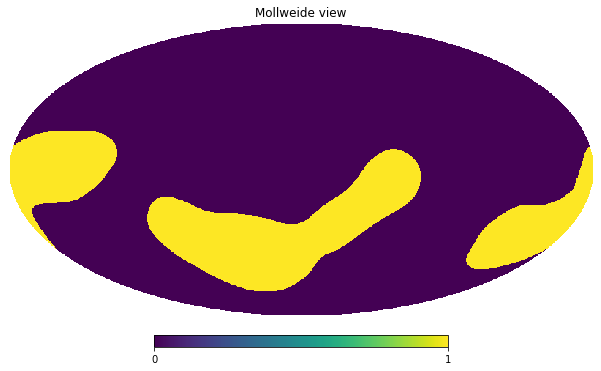

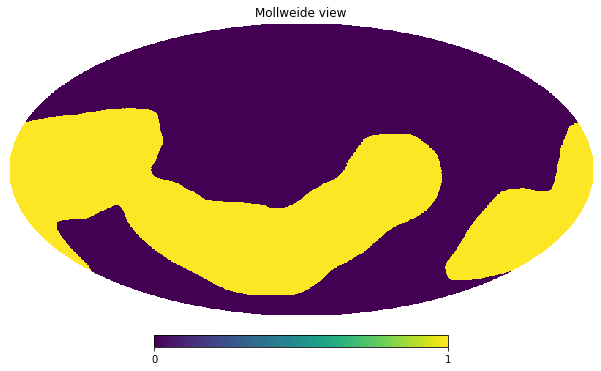

In [3]:
hp.mollview(m0)
hp.mollview(m1)
hp.mollview(m2)

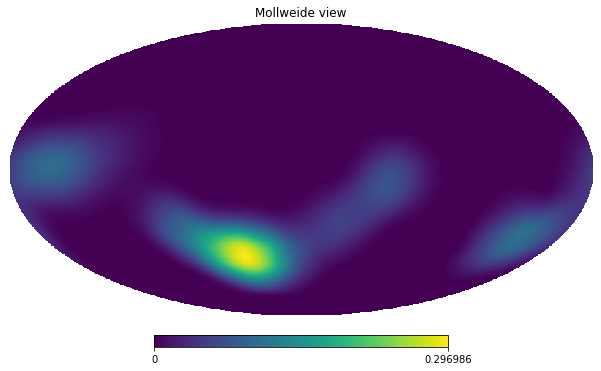

In [63]:
mask = hp.read_map('/global/homes/s/sebibel/git/lerepi/lerepi/data/dc08/masks/mask_r100.fits')
hp.mollview(mask)

# Derive transferfunction

In [13]:
beam = 2.3
lmax_transf = 2048
tf = hp.gauss_beam(beam / 180. / 60. * np.pi, lmax=lmax_transf) * hp.pixwin(2048, lmax=lmax_transf)

In [30]:
def TEBlm_f(simidx):
    '''
    Returns fiducial ffp10 powerspectrum
    '''
    ffp10scalmTEB = 1e6 * hp.read_alm('/project/projectdirs/cmb/data/generic/cmb/ffp10/mc/scalar/ffp10_lensed_scl_cmb_000_alm_mc_%04d.fits'%simidx, hdu=(1,2,3))
    return ffp10scalmTEB

tebmap_f = np.array([hp.alm2map(TEBlm_f(simidx), nside=2048, pol=False) for simidx in simids]) # almTEB -> mapTEB

In [63]:
ClEE_f = ps.map2cl(tebmap_f[0,1], mask=mask, lmax=lmax, lmax_mask=lmax)
ClBB_f = ps.map2cl(tebmap_f[0,2], mask=mask, lmax=lmax, lmax_mask=lmax)

In [ ]:
Cl_fxD = ps.map2cl(tebmap_f[0,1]-, mask=mask, lmax=lmax, lmax_mask=lmax)

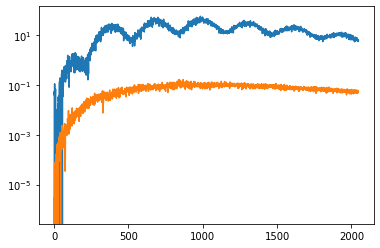

In [64]:
plt.plot(ClEE_f*scale_ps)
plt.plot(ClBB_f*scale_ps)
plt.yscale('log')

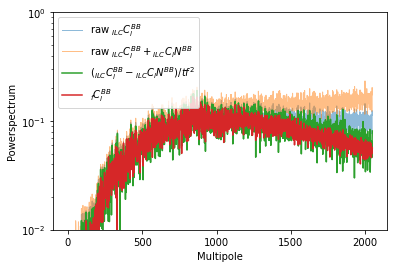

In [105]:
plt.plot(Cl[1]*scale_ps, label=r'raw $_{ILC}C_l^{BB}$', lw=1, alpha=0.5)
plt.plot((Cl[1]+ClN[1])*scale_ps, label=r'raw $_{ILC}C_l^{BB}+_{ILC}C_lN^{BB}$', lw=1, alpha=0.5)
# plt.plot(1/tf**2, label=r"$Tf^{2'3''}_p$")

plt.plot((Cl[1]-ClN[1])*scale_ps/tf[:2048]**2, label=r'$(_{ILC}C_l^{BB} -_{ILC}C_lN^{BB}) /tf^2$')
plt.plot(ClBB_f*scale_ps, label=r'$_fC_l^{BB}$')

plt.yscale('log')
plt.xlabel('Multipole')
plt.ylabel('Powerspectrum')

plt.ylim((1e-2,1e0))
plt.legend()